# Pattern Mining

## Heart Failure Dataset

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm
from mlxtend.preprocessing import TransactionEncoder

### Discretize Numeric Variables with qcut a "Quantile-based discretization function."
From the pandas.qcut documentation:

"Discretize variable into equal-sized buckets based on rank or based on sample quantiles"

In [2]:
data: pd.DataFrame = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

b_vars = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"] 
numeric_vars = data.select_dtypes(include='number').columns
for to_drop in b_vars:
    numeric_vars = numeric_vars.drop(to_drop)
    
for n in range(len(numeric_vars)):
    num_unique = len(list(set(data[numeric_vars[n]].values)))

    data[numeric_vars[n]] = pd.qcut(data[numeric_vars[n]],8)

data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,"(70.0, 75.0]",0,"(573.25, 582.0]",0,"(13.999, 25.0]",1,"(262000.0, 270250.0]","(1.4, 1.9]","(112.999, 132.0]",1,0,"(3.999, 30.0]",1
1,"(51.0, 55.75]",0,"(964.75, 7861.0]",0,"(35.0, 38.0]",0,"(262000.0, 270250.0]","(1.0, 1.1]","(134.0, 136.0]",1,0,"(3.999, 30.0]",1
2,"(60.0, 65.0]",0,"(116.5, 164.75]",0,"(13.999, 25.0]",0,"(25099.999, 166000.0]","(1.2, 1.4]","(112.999, 132.0]",1,1,"(3.999, 30.0]",1
3,"(46.0, 51.0]",1,"(72.75, 116.5]",0,"(13.999, 25.0]",0,"(166000.0, 212500.0]","(1.4, 1.9]","(136.0, 137.0]",1,0,"(3.999, 30.0]",1
4,"(60.0, 65.0]",1,"(116.5, 164.75]",1,"(13.999, 25.0]",0,"(303500.0, 362000.0]","(1.9, 9.4]","(112.999, 132.0]",0,0,"(3.999, 30.0]",1


### Patterns

[0.2, 0.1, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
Processing 14 combinations | Sampling itemset size 14320
19791 patterns


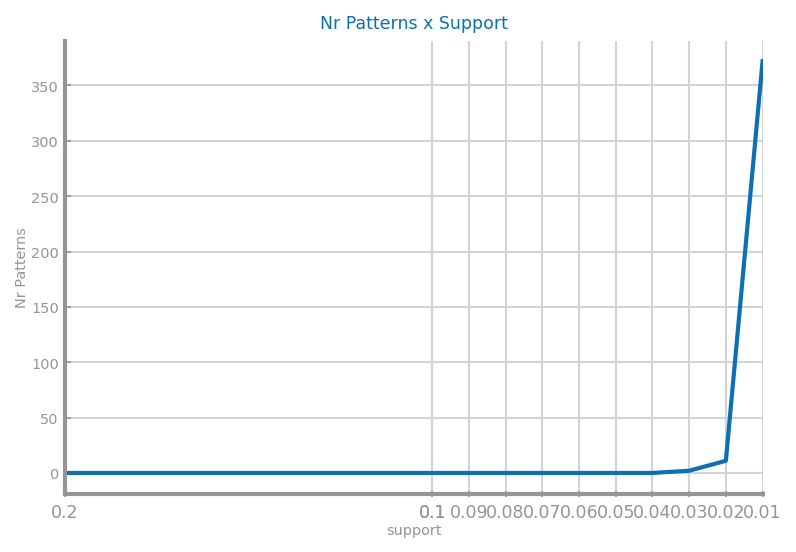

In [3]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]
print(var_min_sup)

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [4]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence

In [5]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 2976813 rules


Analyse per confidence...


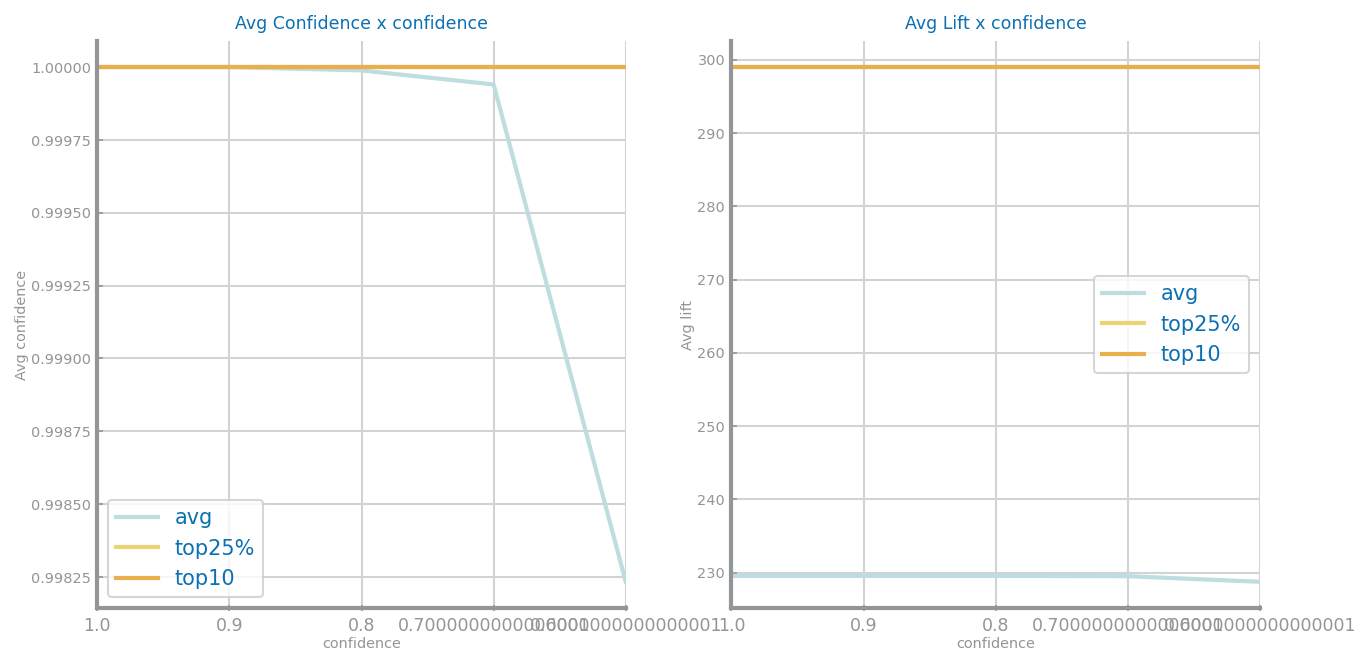

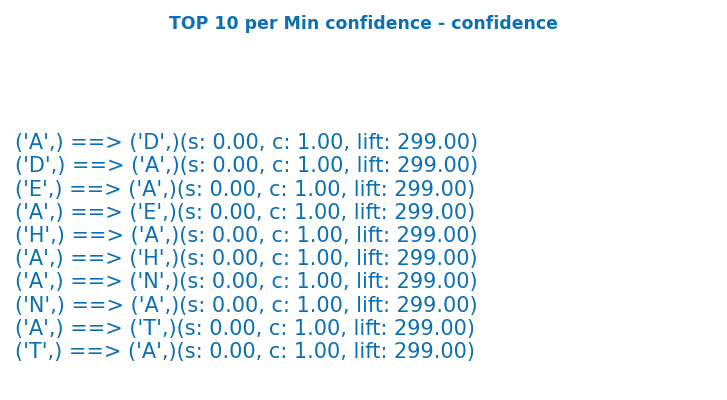

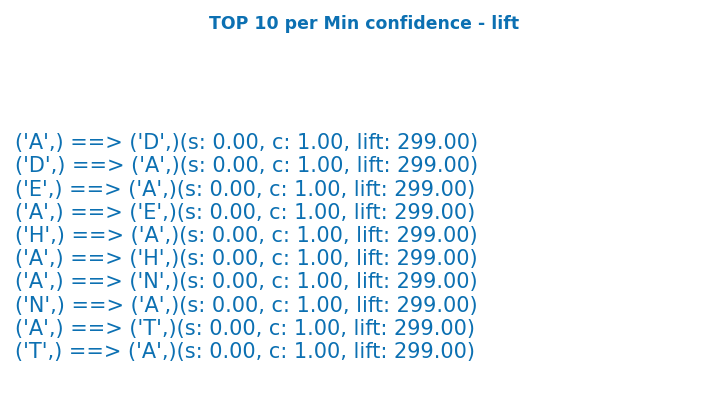

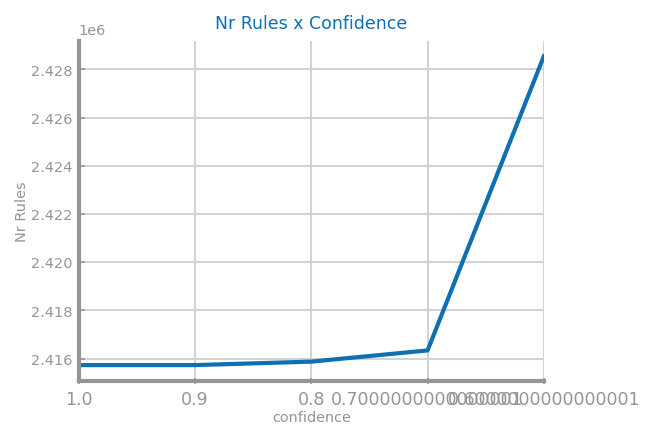

In [6]:
if len(rules) > 0 :
    var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
    nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
    ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support

In [7]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [8]:
if len(rules) > 0:
    var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
    nr_rules_cf = analyse_per_metric(rules, 'support', var_min_conf)
    ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Support', xlabel='support', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Lift

In [9]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per lift...


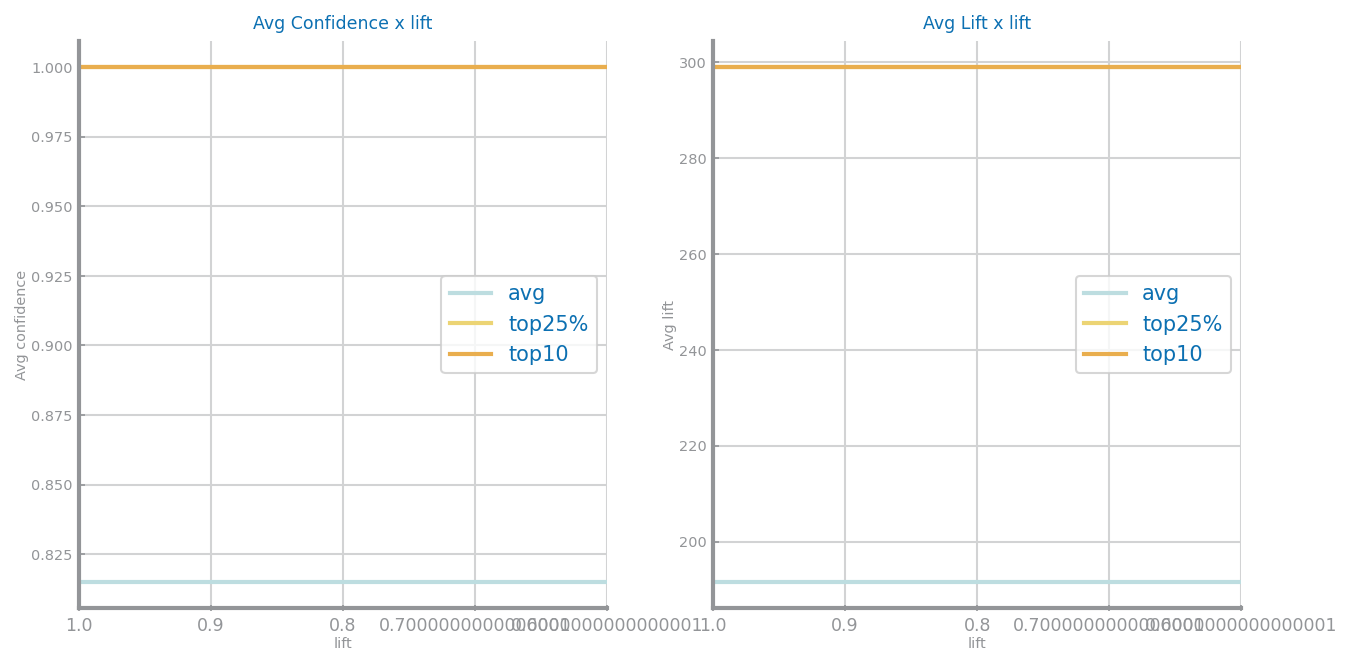

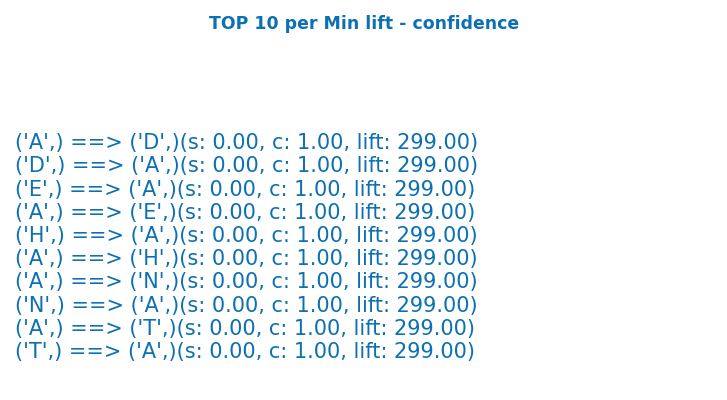

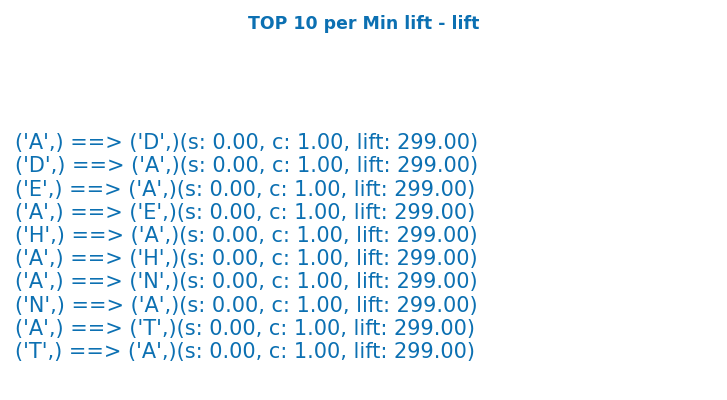

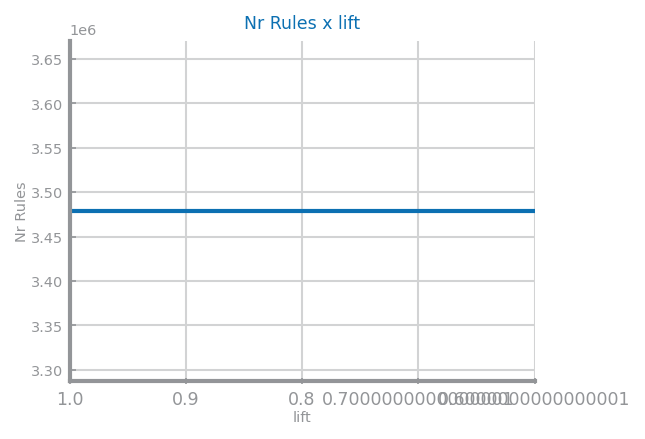

In [10]:
if len(rules) > 0:
    var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
    nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
    ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage

In [11]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [12]:
if len(rules) > 0:
    var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
    nr_rules_cf = analyse_per_metric(rules, 'leverage', var_min_conf)
    ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x leverage', xlabel='leverage', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction

In [13]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


In [ ]:
if len(rules) > 0:
    var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
    nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
    ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

Analyse per conviction...


<br/>
<br/>
<br/>
<br/>
<br/>